In [ ]:
import os
import warnings
import keras
import matplotlib.style as style
import numpy as np
import pandas as pd
import tables
from PIL import Image
from keras import models, layers
from keras import optimizers
from keras.applications import VGG16
from keras.callbacks import Callback
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

style.use('seaborn-whitegrid')
warnings.filterwarnings(action='ignore')

In [5]:
hdf5_file = tables.open_file('train_test_split.h5', mode='r')
X_train_rgb = np.array(hdf5_file.root.X_train_rgb)
y_train_rgb = np.array(hdf5_file.root.y_train_rgb)
X_test_rgb = np.array(hdf5_file.root.X_test_rgb)
y_test_rgb = np.array(hdf5_file.root.y_test_rgb)
hdf5_file.close()

### Open images and convert to NumPy arrays

In [8]:
pic = Image.open('./data/gestures_data/00/01_palm/frame_00_01_0001.png')

In [ ]:
pic = Image.open('./data/gestures_data/00/01_palm/frame_00_01_0001.png')

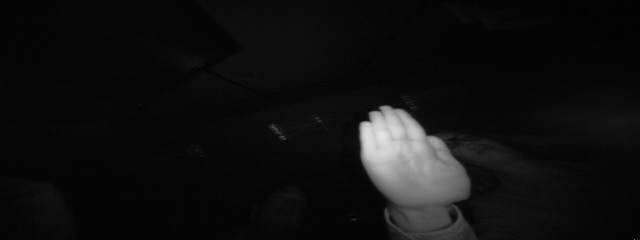

In [16]:
pic

In [17]:
a = np.asarray(pic)

In [29]:
a_array = pd.DataFrame(a)

In [34]:
max(a_array)

639

In [4]:
! open /Users/brenner/project_kojak/data/gestures_data

In [4]:
image = image_utils.load_img(path='data/frame_02.png', target_size=(224, 224))
image = image_utils.img_to_array(image)

In [5]:
image.shape

(224, 224, 3)

### Read in and process data, do train-test split (stratified by person)

In [3]:
lookup = {}
reverselookup = dict()
count = 0
for j in os.listdir('/home/ubuntu/project_kojak/data/gestures_data/00'):
    if not j.startswith('.'):
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1

In [7]:
# Get our variables to put into large dataframe
x_data = []
y_data = []
image_path = []
person = []
gesture = []
image_rgb = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('/home/ubuntu/project_kojak/data/gestures_data/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('/home/ubuntu/project_kojak/data/gestures_data/0' + 
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                person.append(i)
                gesture.append(j)
                path = '/home/ubuntu/project_kojak/data/gestures_data/0' + \
                                 str(i) + '/' + j + '/' + k
                image_path.append(path)
                
                img2rgb = Image.open(path)
                img2rgb = img2rgb.resize((224, 224))
                img2rgb = np.array(img2rgb)
                image_rgb.append(img2rgb)

                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
    print(f'{datacount} images collected so far.')

2000 images collected so far.
4000 images collected so far.
6000 images collected so far.
8000 images collected so far.
10000 images collected so far.
12000 images collected so far.
14000 images collected so far.
16000 images collected so far.
18000 images collected so far.
20000 images collected so far.


In [20]:
def process_data(x_data, y_data):
    x_data = np.array(x_data, dtype = 'float32')
    # x_data = np.array(x_data, dtype=np.uint8)
    x_data = x_data.reshape((len(x_data), 224, 224, 1))
    x_data /= 255
    
    y_data = np.array(y_data)
    y_data = y_data.reshape(len(x_data), 1)
    y_data = to_categorical(y_data)
    return x_data, y_data

def process_data_rgb(x_data, y_data):
    x_data = np.array(x_data, dtype = 'float32')
    # x_data = np.array(x_data, dtype=np.uint8)
    x_data = x_data.reshape((len(x_data), 224, 224, 3))
    x_data /= 255
    
    y_data = np.array(y_data)
#     y_data = y_data.reshape(len(x_data), 1)
    y_data = to_categorical(y_data)
    return x_data, y_data

In [16]:
y_data_2 = []
for y in y_data:
    y_data_2.extend(y)

In [17]:
d = {'image_path':image_path, 'person':person, 'gesture':gesture, 'image_rgb': image_rgb, 'image_bw_x': x_data, 'image_bw_y': y_data_2}
df = pd.DataFrame(d)
df['gesture_num'] = df['gesture'].apply(lambda x: x[1:2])
df['gesture_name'] = df['gesture'].apply(lambda x: x[3:])

In [18]:
df.head(1)

,gesture,image_bw_x,image_bw_y,image_path,image_rgb,person,gesture_num,gesture_name
0,06_index,"[[6, 6, 6, 6, 7, 7, 8, 7, 6, 5, 6, 6, 7, 6, 6,...",[0],/home/ubuntu/project_kojak/data/gestures_data/...,"[[[6.0, 6.0, 6.0], [6.0, 6.0, 6.0], [6.0, 6.0,...",0,6,index


### Save/load images dataframe

In [17]:
# df.to_csv('images_csv.csv', index=False)
df = pd.read_csv('images_csv')

### Train-Test Split

In [10]:
x_data, y_data = process_data(x_data, y_data)

In [11]:
# Black and white images, shape (16000,224,224,1)
X_train_bw = x_data[:16000]
y_train_bw = y_data[:16000]
X_test_bw = x_data[16000:]
y_test_bw = y_data[16000:]

In [21]:
x_data_rgb, y_data_rgb = process_data_rgb(image_rgb, y_data)

In [22]:
X_train_rgb = x_data_rgb[:16000]
y_train_rgb = y_data[:16000]
X_test_rgb = x_data_rgb[16000:]
y_test_rgb = y_data[16000:]

In [58]:
df.columns

Index(['gesture', 'image_bw_x', 'image_bw_y', 'image_path', 'image_rgb',
       'person', 'gesture_num', 'gesture_name'],
      dtype='object')

In [63]:
X_train_rgb = df.iloc[:16000, 4]

In [9]:
X_train, y_train = get_data(0,8)
X_train, y_train = process_data(X_train, y_train)

In [50]:
X_test, y_test = get_data(8,10)
X_test, y_test = process_data(X_test, y_test)

### Save the X and y

### VGG Models

In [ ]:
# Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(
                        weights='imagenet',
                        include_top=False,
                        )
model_vgg16_conv.summary()

# Create your own input format (here 224x224x3)
input_img = Input(shape=(224, 224, 3), name ='image_input')

# makes the layers non-trainable
for layer in model_vgg16_conv.layers:
    layer.trainable = False
    
# Use the generated model 
output_vgg16_conv = model_vgg16_conv(input_img)
    
# Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(4096, activation='relu', name='fc1')(x)
# x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(10, activation='softmax', name='predictions')(x) # here the 2 indicates binary (3 or more is multiclass)

# Create your own model 
my_model = Model(input=input_img, output=x)

# In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()

In [100]:
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
optimizer1 = optimizers.Adam()  # Adam is like a gradient descent (way to find parameters)

In [ ]:
base_model = model1 # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
#### Playing with other architectures
#     x = Flatten() (x)
#     x = Dense(64) (x)
#     x = Activation('relu') (x)
#     x = Dropout(0.5) (x)
#     x = Dense(32) (x)
#     x = Activation('relu') (x)
#     x = Dropout(0.5) (x)
####
predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# Train top layer
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(loss='categorical_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

# model.summary()

model.fit(X_train[:500], y_train[:500], epochs=4, batch_size=64, validation_data=(X_test[:500], y_test[:500]), verbose=1, callbacks = [MetricsCheckpoint('logs')])

In [ ]:
from sklearn.utils import class_weight
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

#### Non-VGG model

In [33]:
from keras import models, layers

model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224,3))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [34]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.fit(x_data, y_data, epochs=1, batch_size=64, verbose=1)
# model.fit_generator(datagen, samples_per_epoch=len(x_data), epochs=100)
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1, validation_data=(X_test, y_test))

### Image Augmentation - CORRECT

In [26]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [27]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_rgb)

In [35]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train_rgb, y_train_rgb, batch_size=128),
                    steps_per_epoch=len(X_train_rgb) / 128, epochs=10, validation_data=(X_test_rgb, y_test_rgb))

Epoch 1/10
125/125 [==============================] - 168s 1s/step - loss: 1.8282 - acc: 0.3467 - val_loss: 1.9315 - val_acc: 0.3807
Epoch 2/10
125/125 [==============================] - 167s 1s/step - loss: 0.8788 - acc: 0.6963 - val_loss: 1.5761 - val_acc: 0.6853
Epoch 3/10
125/125 [==============================] - 166s 1s/step - loss: 0.5027 - acc: 0.8275 - val_loss: 1.5477 - val_acc: 0.5607
Epoch 4/10
125/125 [==============================] - 167s 1s/step - loss: 0.3236 - acc: 0.8941 - val_loss: 1.4435 - val_acc: 0.5873
Epoch 5/10
125/125 [==============================] - 166s 1s/step - loss: 0.2333 - acc: 0.9234 - val_loss: 1.2353 - val_acc: 0.7335
Epoch 6/10
125/125 [==============================] - 166s 1s/step - loss: 0.1762 - acc: 0.9436 - val_loss: 1.3766 - val_acc: 0.5597
Epoch 7/10
125/125 [==============================] - 166s 1s/step - loss: 0.1513 - acc: 0.9544 - val_loss: 1.3076 - val_acc: 0.6288
Epoch 8/10
125/125 [==============================] - 167s 1s/step - 

In [28]:
x_data.shape

(16000, 224, 224, 1)

In [24]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

2000/2000 [==============================] - 6s 3ms/step
Accuracy:1.0


### Save/reload the model

In [110]:
# model.save('my_model_vgg.h5')
model.save('vgg_with_augmentation.h5')

In [6]:
from keras.models import load_model
model = load_model('my_model_2.h5')
# model = load_model('my_model_with_augmentation.h5')

In [ ]:
predictions = model.predict_classes(x_data)
# predictions = model.predict(x_data_2)

In [102]:
from sklearn.metrics import confusion_matrix, classification_report

### Model #2 Classification Metrics

In [101]:
# confusion_matrix(y_data, predictions)

array([[233,   0,   0,  71,   0,   0,   0,  80,   7,   9],
       [ 32, 330,   3,   0,  12,   4,  11,   0,   0,   8],
       [  8,   6, 132,  31,  21, 145,  17,  22,  14,   4],
       [ 17,   3,   0, 282,   7,   6,  16,  16,  49,   4],
       [  0,   0,   0,   6, 394,   0,   0,   0,   0,   0],
       [  0,   0,   0, 176,  21, 203,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 400,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 100, 300,   0,   0],
       [  0,   0,   0,   0,   0,   0,  92,   0, 308,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 400]])

In [104]:
# print(classification_report(y_data, predictions))

             precision    recall  f1-score   support

          0       0.80      0.58      0.68       400
          1       0.97      0.82      0.89       400
          2       0.98      0.33      0.49       400
          3       0.50      0.70      0.58       400
          4       0.87      0.98      0.92       400
          5       0.57      0.51      0.54       400
          6       0.63      1.00      0.77       400
          7       0.72      0.75      0.73       400
          8       0.81      0.77      0.79       400
          9       0.94      1.00      0.97       400

avg / total       0.78      0.75      0.74      4000



### Model w/ VGG Classification Metrics

In [ ]:


for prediction in pred[:100]:
    print(np.where(prediction == prediction.max())[0][0])

In [58]:
np.where( == prediction.max())[0][0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [65]:
correct = 0
incorrect = 0
for i in range(len(pred)):
    if (np.where(pred[i] == pred[i].max())[0][0]) == (np.where(y_data_2[i] == y_data_2[i].max())[0][0]):
        correct +=1
    else:
        incorrect +=1
print(correct, incorrect)

2908 1092


In [42]:
def get_classification_reports(y_pred, y_true):
    Y_pred_classes = np.array(np.argmax(y_pred))  # reconverts back from one hot encoded 
    Y_true = np.array(np.argmax(y_true))  # reconverts back from one hot encoded
    print(confusion_matrix(Y_true, Y_pred_classes))
    print(classification_report(Y_true, Y_pred_classes))

In [53]:
pred = model.predict_classes(X_test)

In [55]:
import pickle
with open('pred.pickle', 'wb') as handle:
    pickle.dump(pred, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
pred = pred.reshape(len(pred),)

In [ ]:
Y_pred_classes = np.argmax(pred,axis = 1)  # reconverts back from one hot encoded 
Y_true = np.argmax(y_data_2,axis = 1)  # reconverts back from one hot encoded

In [129]:
confusion_matrix(Y_true, Y_pred_classes)

array([[388,   0,   0,   0,   0,   0,   0,   0,  12,   0],
       [  0, 400,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 201, 151,   0,   0,  48,   0,   0,   0],
       [  0,   0,   2, 340,  58,   0,   0,   0,   0,   0],
       [  0,  48, 117,  32, 201,   2,   0,   0,   0,   0],
       [  0,   0,   0,  47,   0, 301,  52,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 400,   0,   0,   0],
       [  0,  85,   0, 204,  92,  19,   0,   0,   0,   0],
       [  4,   2,  15,  14,  25,   0,   0,   0, 340,   0],
       [  0,   0,  10,  53,   0,   0,   0,   0,   0, 337]])

In [131]:
print(classification_report(Y_true, Y_pred_classes))

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       400
          1       0.75      1.00      0.86       400
          2       0.58      0.50      0.54       400
          3       0.40      0.85      0.55       400
          4       0.53      0.50      0.52       400
          5       0.93      0.75      0.83       400
          6       0.80      1.00      0.89       400
          7       0.00      0.00      0.00       400
          8       0.97      0.85      0.90       400
          9       1.00      0.84      0.91       400

avg / total       0.70      0.73      0.70      4000



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [150]:
y_true = np.argmax(y_test_rgb, axis=1)

### Model with Image Augmentation

In [77]:
print(confusion_matrix(y_true, pred))
print('\n')
print(classification_report(y_true, pred))

[[400   0   0   0   0   0   0   0   0   0]
 [  0 312   0   0   0  88   0   0   0   0]
 [  0   0 368  32   0   0   0   0   0   0]
 [  8   0   0 372   0  20   0   0   0   0]
 [ 19   0 226  87  68   0   0   0   0   0]
 [  0   0   0   0   0 400   0   0   0   0]
 [  0   0   0   0   0   0 400   0   0   0]
 [  0   0   0 190   0   0   0 210   0   0]
 [200   0  10  17   0  53   0   0 120   0]
 [  0   0   0   0   0   0   0   0   0 400]]


             precision    recall  f1-score   support

          0       0.64      1.00      0.78       400
          1       1.00      0.78      0.88       400
          2       0.61      0.92      0.73       400
          3       0.53      0.93      0.68       400
          4       1.00      0.17      0.29       400
          5       0.71      1.00      0.83       400
          6       1.00      1.00      1.00       400
          7       1.00      0.53      0.69       400
          8       1.00      0.30      0.46       400
          9       1.00      1.00    

In [81]:
for i, v in enumerate(np.bincount(pred)):
    print(i, v)

0 627
1 312
2 604
3 698
4 68
5 561
6 400
7 210
8 120
9 400


In [85]:
for i, v in enumerate(np.bincount(y_true)):
    print(i, v)

0 400
1 400
2 400
3 400
4 400
5 400
6 400
7 400
8 400
9 400


In [45]:
pred = model.predict_classes(X_test_rgb)

In [64]:
y_true = np.argmax(y_test_rgb, axis=1)

In [47]:
print(confusion_matrix(y_true, pred))
print('\n')
print(classification_report(y_true, pred))

[[400   0   0   0   0   0   0   0   0   0]
 [  0 400   0   0   0   0   0   0   0   0]
 [  0   0 233 167   0   0   0   0   0   0]
 [  0  37   0 306   0  57   0   0   0   0]
 [101   2  46 140  30  81   0   0   0   0]
 [  0   0   0   0   0 400   0   0   0   0]
 [  0   0   0   0   0   0 400   0   0   0]
 [  0   0   0 396   0   0   0   4   0   0]
 [111 162   0  73   0  11   0   0  43   0]
 [  0   0   1   0   0   0   0   0   0 399]]


             precision    recall  f1-score   support

          0       0.65      1.00      0.79       400
          1       0.67      1.00      0.80       400
          2       0.83      0.58      0.69       400
          3       0.28      0.77      0.41       400
          4       1.00      0.07      0.14       400
          5       0.73      1.00      0.84       400
          6       1.00      1.00      1.00       400
          7       1.00      0.01      0.02       400
          8       1.00      0.11      0.19       400
          9       1.00      1.00    

### VGG with Image Aug Evaluation

In [189]:
pred = model.predict(X_test_rgb)

In [190]:
pred2 = np.argmax(pred, axis=1)

In [191]:
pred2.shape

(4000,)

In [192]:
print(confusion_matrix(y_true, pred2))
print('\n')
print(classification_report(y_true, pred2))

[[260  57   3   0   0   0  44   0   0  36]
 [  0 331   0   0   0   0   0   0   0  69]
 [  0   0 351   0   0   0   0   0   0  49]
 [  0   0  11 286   0   0  29   0   0  74]
 [  0   0 169   0 179   0   0  52   0   0]
 [  0   0   0   0   0 200  10   0   0 190]
 [  0   0   0   0   0   0 308   0   0  92]
 [  0   8   0   0   0   0   0 392   0   0]
 [ 15  71  38   0   0   0   5  82 189   0]
 [  0   0   0   0   0   0   0   0   0 400]]


             precision    recall  f1-score   support

          0       0.95      0.65      0.77       400
          1       0.71      0.83      0.76       400
          2       0.61      0.88      0.72       400
          3       1.00      0.71      0.83       400
          4       1.00      0.45      0.62       400
          5       1.00      0.50      0.67       400
          6       0.78      0.77      0.77       400
          7       0.75      0.98      0.85       400
          8       1.00      0.47      0.64       400
          9       0.44      1.00    

#### Get predictions from new images

In [37]:
def get_prediction_from_image(path):
    x_data = []
    path = path
    
    img = Image.open(path).convert('L')
    img = img.resize((224, 224))
    arr = np.array(img)
    x_data.append(arr)
    
    x_data = np.array(x_data, dtype = 'float32')
    # x_data = np.array(x_data, dtype=np.uint8)
    x_data = x_data.reshape((len(x_data), 224, 224, 1))
    x_data /= 255
    return gesture_names[model.predict_classes(x_data)[0]]

In [145]:
gesture_names = {0: 'Palm',
                 1: 'L',
                 2: 'Fist',
                 3: 'Fist - Moved',
                 4: 'Thumb',
                 5: 'Index',
                 6: 'OK',
                 7: 'Palm - Moved',
                 8: 'C',
                 9: 'Down'}

def predict_rgb_image(path):
    img2rgb = image_utils.load_img(path=path, target_size=(224, 224))
    img2rgb = image_utils.img_to_array(img2rgb)
#     image_rgb.append(img2rgb)
    img2rgb = img2rgb.reshape(1, 224, 224, 3)
    return gesture_names[model.predict_classes(img2rgb)[0]]

# NOTE: This is a convenience function for VGG with augmentation since it doesn't support .predict_classes
def predict_rgb_image_vgg(path):
    img2rgb = image_utils.load_img(path=path, target_size=(224, 224))
    img2rgb = image_utils.img_to_array(img2rgb)
#     image_rgb.append(img2rgb)
    img2rgb = img2rgb.reshape(1, 224, 224, 3)
    return np.argmax(model.predict(img2rgb))

In [122]:
model.predict(X_test_rgb[0:2])

array([[6.6374824e-03, 6.9680595e-01, 2.4728321e-05, 2.5968717e-05,
        1.4618971e-05, 9.3200346e-03, 3.3653744e-02, 1.1060607e-04,
        7.4478728e-04, 2.5266212e-01],
       [9.7006363e-01, 2.4372098e-04, 1.1987788e-05, 1.5070122e-05,
        7.5034157e-05, 1.9329778e-05, 2.8733697e-02, 2.6797192e-04,
        5.0295459e-04, 6.6551620e-05]], dtype=float32)

In [137]:
predict_rgb_image_vgg('images_to_predict/test - palm.jpg')

'10_down'

In [179]:
predict_rgb_image_vgg('./data/gestures_data/02/01_palm/frame_02_01_0001.png')

3

In [177]:
predict_rgb_image_vgg('./data/gestures_data/04/03_fist/frame_04_03_0005.png')

4

In [96]:
predict_rgb_image('./data/gestures_data/00/01_palm/frame_00_01_0007.png')

'Palm'

In [102]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [103]:
# load VGG16
#Get back the convolutional part of a VGG network trained on ImageNet
import keras
from keras import models, layers, optimizers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.models import Model
imageSize=224
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = optimizers.Adam()

In [109]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

base_model = model1  # Topless
# Add top layer
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(128, activation='relu', name='fc3')(x)
x = Dropout(0.5)(x)

predictions = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Train top layer
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

datagen.fit(X_train_rgb)

# Fit model
model.fit_generator(datagen.flow(X_train_rgb, y_train_rgb, batch_size=128),
                    steps_per_epoch=len(X_train_rgb) / 128, epochs=10, validation_data=(X_test_rgb, y_test_rgb))


Epoch 1/10
125/125 [==============================] - 173s 1s/step - loss: 0.7088 - acc: 0.7607 - val_loss: 0.8900 - val_acc: 0.7000
Epoch 2/10
125/125 [==============================] - 167s 1s/step - loss: 0.0782 - acc: 0.9760 - val_loss: 0.8731 - val_acc: 0.7560
Epoch 3/10
125/125 [==============================] - 167s 1s/step - loss: 0.0447 - acc: 0.9857 - val_loss: 1.1522 - val_acc: 0.7240
Epoch 4/10
125/125 [==============================] - 167s 1s/step - loss: 0.0440 - acc: 0.9864 - val_loss: 0.8571 - val_acc: 0.7150
Epoch 5/10
125/125 [==============================] - 167s 1s/step - loss: 0.0309 - acc: 0.9901 - val_loss: 1.0008 - val_acc: 0.7480
Epoch 6/10
125/125 [==============================] - 167s 1s/step - loss: 0.0200 - acc: 0.9933 - val_loss: 1.1004 - val_acc: 0.7618
Epoch 7/10
125/125 [==============================] - 167s 1s/step - loss: 0.0177 - acc: 0.9949 - val_loss: 1.1796 - val_acc: 0.7278
Epoch 8/10
125/125 [==============================] - 167s 1s/step - 

In [26]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45.,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [27]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_rgb)

In [35]:
# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train_rgb, y_train_rgb, batch_size=128),
                    steps_per_epoch=len(X_train_rgb) / 128, epochs=10, validation_data=(X_test_rgb, y_test_rgb))


Epoch 1/10
125/125 [==============================] - 168s 1s/step - loss: 1.8282 - acc: 0.3467 - val_loss: 1.9315 - val_acc: 0.3807
Epoch 2/10
125/125 [==============================] - 167s 1s/step - loss: 0.8788 - acc: 0.6963 - val_loss: 1.5761 - val_acc: 0.6853
Epoch 3/10
125/125 [==============================] - 166s 1s/step - loss: 0.5027 - acc: 0.8275 - val_loss: 1.5477 - val_acc: 0.5607
Epoch 4/10
125/125 [==============================] - 167s 1s/step - loss: 0.3236 - acc: 0.8941 - val_loss: 1.4435 - val_acc: 0.5873
Epoch 5/10
125/125 [==============================] - 166s 1s/step - loss: 0.2333 - acc: 0.9234 - val_loss: 1.2353 - val_acc: 0.7335
Epoch 6/10
125/125 [==============================] - 166s 1s/step - loss: 0.1762 - acc: 0.9436 - val_loss: 1.3766 - val_acc: 0.5597
Epoch 7/10
125/125 [==============================] - 166s 1s/step - loss: 0.1513 - acc: 0.9544 - val_loss: 1.3076 - val_acc: 0.6288
Epoch 8/10
125/125 [==============================] - 167s 1s/step - 

In [ ]:
pretrainedNetwork(X_train_rgb, y_train_rgb, X_test_rgb, y_test_rgb, model1, 10, 10, optimizer1)

In [31]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(Dropout(0.25, seed=21))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


In [32]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train_rgb, y_train_rgb, epochs=10, batch_size=64, verbose=1, validation_data=(X_test_rgb, y_test_rgb))